In [1]:
from src import *

import numpy as np
import torch
from torch import optim, nn
import torchvision

import matplotlib.pyplot as plt

import time
from tqdm.auto import tqdm


# CUDA

In [2]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch is using', device)

PyTorch is using cuda


# Parameters

In [3]:
from configs import *

# Training related functions

In [4]:
def train(epoch,
          model, train_loader,
          criterion, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = criterion(recon_batch, data, mu, logvar)
        train_loss += loss.item() / len(train_loader.dataset)
        loss.backward()
        optimizer.step()
        
    return train_loss

def reconstruct(model, test_loader):
    model.eval()
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, _, _ = model(data, is_train=False)

            n = min(data.shape[0], 8)
            samples = data[:n].cpu().numpy()
            recons = recon_batch[:n].cpu().numpy()
            
            break

    return samples, recons

def test(epoch,
         model, test_loader,
         criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = criterion(recon_batch, data, mu, logvar)
            test_loss += loss.item() / len(test_loader.dataset)
    
    return test_loss


# Visualization related functions

In [5]:
def to_rgb(sample):
    r = sample[0]
    g = sample[1]
    b = sample[2]
    rgb = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)
    return rgb

def visualize_imgs(samples, recons):
    (n,c,h,w) = samples.shape
    plt.figure(figsize=(28, 8))
    
    if (c == 3):
        for i in range(n):
            plt.subplot(2, n, i + 1)
            plt.imshow(to_rgb(samples[i]))

            plt.subplot(2, n, i + 1 + n)
            plt.imshow(to_rgb(recons[i]))
        plt.show()
    elif (c == 1):
        for i in range(n):
            plt.subplot(2, n, i + 1)
            plt.imshow(samples[i].reshape(28, 28), cmap='gray_r')

            plt.subplot(2, n, i + 1 + n)
            plt.imshow(recons[i].reshape(28, 28), cmap='gray_r')
        plt.show()
    

# Main

### Dataset

In [6]:
transforms = transforms.Compose([
    transforms.Resize(size=(resize_h, resize_w)),
    transforms.ToTensor(),    
])
dataset = CustomDataset(dataset_name=dataset_name, transforms=transforms)
train_loader = dataset.get_dataloader(is_train=True,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      prefetch_factor=prefetch_factor)
test_loader = dataset.get_dataloader(is_train=False,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=num_workers,
                                     prefetch_factor=prefetch_factor)

### Model

In [7]:
input_dim = resize_h, resize_w, input_ch
model = IWAE(input_dim, channels, num_z, num_samples).to(device)
print(model)

criterion = IW_ELBO(input_dim, num_samples)
optimizer = optim.Adam(model.parameters(), lr=init_lr)

IWAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): GELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): GELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): GELU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): GELU()
    (14): Dropout(p=0.1, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (16): GELU()
    (17): Dropout(p=0.1, inplace=False)
    (18): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mu): Linear(in_features=512, out_features=1024, bias=True)
  (z_logvar): Linear(in_features=512, out_features=1024, bias=True

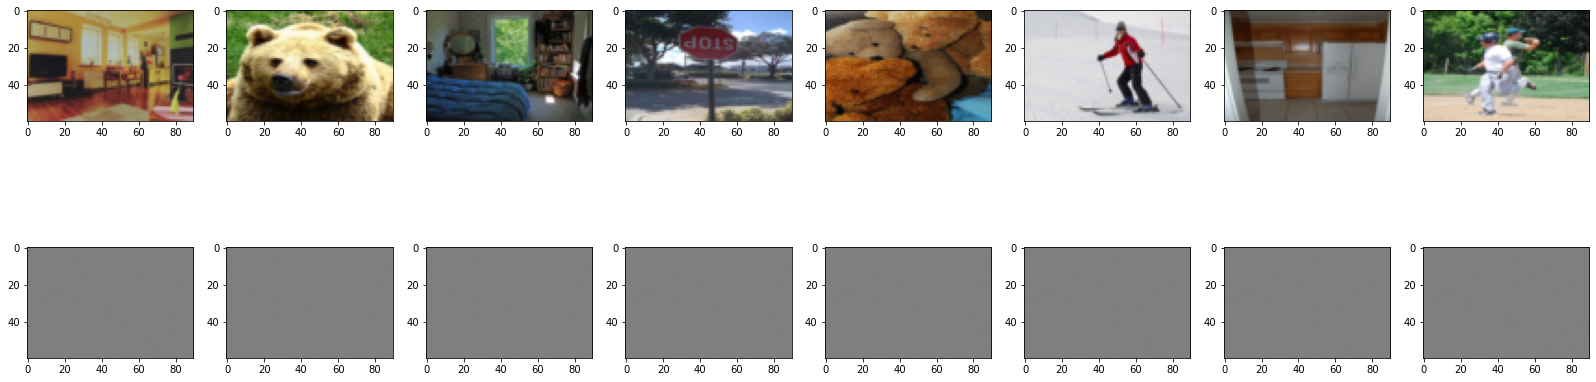

KeyboardInterrupt: 

In [8]:
# Learn
total_time = 0
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    # generate and visualize
    samples, recons = reconstruct(model, test_loader)
    visualize_imgs(samples, recons)
    
    # train
    start_time = time.time()
    train_loss = train(epoch,
                       model, train_loader,
                       criterion, optimizer)
    end_time = time.time()
    train_losses.append(train_loss)
    dt = end_time - start_time
    total_time += dt

    # test
    test_loss = test(epoch,
                     model, test_loader,
                     criterion)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch} / {epochs} in {dt:.2f} secs')
    print(f'Train loss {train_loss:.2f}, Test loss {test_loss:.2f}')

print('Train loss:', train_losses)
print('Test loss:', test_losses)
print(f'Average {total_time / epochs:.2f} secs per epoch consumed')
print(f'Total {total_time:.2f} secs consumed')